In [ ]:
from datetime import datetime
import os

from google.cloud import bigquery, storage
import pandas as pd

# Set up google cloud clients
bigquery_client = bigquery.Client.from_service_account_json("../../config/neuraltwin-545b2b43070a.json")
storage_client = storage.Client.from_service_account_json("../../config/neuraltwin-545b2b43070a.json")

# Agent input

In [ ]:
cloud_storage_location = "gs://neuraltwin/data/wagon_data"  # location of the data in cloud storage, must contain subfolders measurements, failures, metadata
bigquery_dataset = "neuraltwin.wagon_data"  # the agent will create tables in this location
project_id = "neuraltwin"  # your google cloud project id

In [ ]:
TODAY = datetime(year=2025, month=8, day=2)
TODAY_str = TODAY.strftime('%Y_%m_%d')

# Generate bigquery tables for measurements, failures, and metadata from raw data in GCS

In [53]:
def load_folder_into_bigquery(folder_url: str, table_id: str, bigquery_client: bigquery.Client, storage_client: storage.Client):
    """
    Loads all files from a given folder in Google Cloud Storage into a BigQuery table.
    Auto-detects:
        - File format (CSV, NDJSON, Parquet) from a single file in the folder.
        - Schema from the file contents.
    Overwrites the table if it already exists.
    After ingestion:
        - If a column named 'timestamp' exists and is inferred as DATE,
          automatically converts it into TIMESTAMP.
    Assumes all files in the folder are of the same format.
    """

    # Normalize folder path (ensure trailing slash)
    if not folder_url.endswith("/"):
        folder_url += "/"

    # Extract bucket name & prefix from folder URL
    if not folder_url.startswith("gs://"):
        raise ValueError("folder_url must start with 'gs://'")
    bucket_name = folder_url.split("/")[2]
    prefix = "/".join(folder_url.split("/")[3:])

    # Use GCS client to find one file in the folder
    blobs = list(storage_client.list_blobs(bucket_name, prefix=prefix, max_results=1))

    if not blobs:
        raise FileNotFoundError(f"No files found in {folder_url}")

    # Get the first file's extension to determine source format
    first_file = blobs[0].name
    extension = os.path.splitext(first_file)[1].lower()

    # Map file extension to BigQuery source format
    if extension == ".csv":
        source_format = bigquery.SourceFormat.CSV
    elif extension in (".json", ".ndjson"):
        source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON
    elif extension == ".parquet":
        source_format = bigquery.SourceFormat.PARQUET
    else:
        raise ValueError(f"Unsupported file format '{extension}' in {first_file}")

    # Configure the load job
    job_config = bigquery.LoadJobConfig(
        autodetect=True,
        write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
        source_format=source_format
    )

    # Start the load job for all files in the folder
    load_job = bigquery_client.load_table_from_uri(
        f"{folder_url}*",
        table_id,
        job_config=job_config,
    )

    # Wait for completion and handle errors
    try:
        load_job.result()
    except Exception as e:
        print(f"❌ BigQuery load failed: {e}")
        if load_job.errors:
            print("BigQuery job errors:", load_job.errors)
        raise

    # Check if 'timestamp' column exists and its type
    table = bigquery_client.get_table(table_id)
    timestamp_field = next((f for f in table.schema if f.name.lower() == "timestamp"), None)

    if timestamp_field:
        if timestamp_field.field_type.upper() == "DATE":
            print(f"ℹ️ Column 'timestamp' detected as DATE. Converting to TIMESTAMP...")

            query = f"""
            CREATE OR REPLACE TABLE `{table_id}` AS
            SELECT
                CAST(timestamp AS TIMESTAMP) AS timestamp,
                *
            EXCEPT(timestamp)
            FROM `{table_id}`
            """

            bigquery_client.query(query).result()
            print(f"✅ Converted 'timestamp' column from DATE to TIMESTAMP in {table_id}.")
        else:
            print(f"✅ Column 'timestamp' already has type {timestamp_field.field_type}. No conversion needed.")
    else:
        print(f"ℹ️ No 'timestamp' column found in {table_id}.")

    # Fetch the table and report
    destination_table = bigquery_client.get_table(table_id)
    print(f"✅ Loaded {destination_table.num_rows} rows into {table_id} ({source_format}).")

In [ ]:
for data_type in ["measurements", "failures", "metadata"]:
    load_folder_into_bigquery(
        folder_url=f"{cloud_storage_location}/{data_type}/",
        table_id=f"{bigquery_dataset}.{data_type}",
        bigquery_client=bigquery_client,
        storage_client=storage_client
    )

✅ Column 'timestamp' already has type TIMESTAMP. No conversion needed.
✅ Loaded 109973 rows into neuraltwin.wagon_data.measurements (PARQUET).


# Train classification model

In [ ]:
# load training data
training_data = pd.read_gbq(
    f"SELECT * FROM `{bigquery_dataset}.measurements`",
    project_id=project_id,
    dialect="standard"
)
failures = pd.read_gbq(
    f"SELECT id, timestamp FROM `{bigquery_dataset}.failures`",
    project_id=project_id,
    dialect="standard"
)

# create a new column "failure" in training data, default to 0.0
training_data["failure"] = 0.0
# in training data, set the failure flag to 1.0 for rows where id and timestamp match failures table
for _, row in failures.iterrows():
    training_data.loc[
        (training_data["id"] == row["id"]) & (training_data["timestamp"] == row["timestamp"]),
        "failure"
    ] = 1.0
training_data.drop(columns=["id", "timestamp"], inplace=True)

,Description,Value
0,Session id,3232
1,Target,failure
2,Target type,Binary
3,Original data shape,"(109973, 6)"
4,Transformed data shape,"(109973, 6)"
5,Transformed train set shape,"(76981, 6)"
6,Transformed test set shape,"(32992, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.9963,0.9981,1.0000,0.4965,0.6633,0.6616,0.7032,0.0550
qda,Quadratic Discriminant Analysis,0.0036,0.0000,1.0000,0.0036,0.0072,0.0000,0.0000,0.0870
lda,Linear Discriminant Analysis,0.9965,0.9983,0.9783,0.5082,0.6683,0.6667,0.7035,0.0800
gbc,Gradient Boosting Classifier,0.9963,0.8980,0.7815,0.4970,0.6007,0.5990,0.6179,8.1250
lightgbm,Light Gradient Boosting Machine,0.9607,0.8558,0.5093,0.3635,0.3811,0.3780,0.3909,0.4570
knn,K Neighbors Classifier,0.9962,0.9892,0.5017,0.4817,0.4878,0.4860,0.4879,0.3740
ada,Ada Boost Classifier,0.9965,0.9917,0.4980,0.5079,0.4999,0.4981,0.4997,2.3160
dt,Decision Tree Classifier,0.9962,0.7428,0.4874,0.4807,0.4830,0.4811,0.4817,0.1500
rf,Random Forest Classifier,0.9962,0.9980,0.4766,0.4727,0.4696,0.4677,0.4702,1.3770
lr,Logistic Regression,0.9963,0.9983,0.4730,0.4903,0.4787,0.4769,0.4783,2.7370


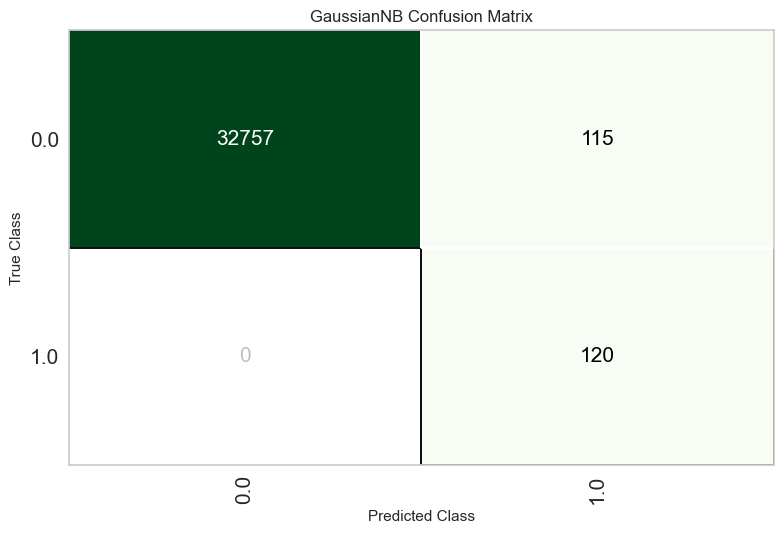

In [ ]:
from pycaret.classification import setup, compare_models, plot_model

clf = setup(data=training_data, target="failure")

best_model = compare_models(sort="Recall")  # Sort models by recall
plot_model(best_model, plot="confusion_matrix")

In [ ]:
# save the model
# import joblib
# joblib.dump(best_model, 'best_model.joblib')

['best_model.joblib']

# Forecasting future measurements using BigQuery ML

In [ ]:
cols_names = training_data.columns.tolist().remove("failure")
cols_names

['speed', 'brake', 'temp', 'vibration', 'battery']

In [ ]:
def forcast_single_column(bigquery_dataset: str, col_name: str, project_id: str) -> pd.DataFrame:
    """
    Forcasts a single column in {bigquery_dataset}.measurements using BigQuery ML's AI.FORECAST function.
    Returns a DataFrame with columns: id, timestamp, <col_name>
    """
    sql = f"""
        SELECT *
        FROM AI.FORECAST(
            TABLE `{bigquery_dataset}.measurements`,
            data_col => '{col_name}',
            timestamp_col => 'timestamp',
            model => 'TimesFM 2.0',
            id_cols => ['id'],
            horizon => 30,
            confidence_level => .75
        )
    """
    forecast = pd.read_gbq(sql, project_id=project_id, dialect="standard")
    forecast[col_name] = forecast["forecast_value"]
    forecast["timestamp"] = forecast["forecast_timestamp"]
    forecast = forecast[["id", "timestamp", col_name]]
    return forecast

all_forecasts = []
for col_name in cols_names:
    all_forecasts.append(forcast_single_column(bigquery_dataset, col_name, project_id))

In [52]:
# merge all forecasts on id and forecast_timestamp
forecast = all_forecasts[0]
for f in all_forecasts[1:]:
    forecast = forecast.merge(f, on=["id", "timestamp"])

In [ ]:
forecast.to_gbq(
    destination_table=f"{bigquery_dataset}.forecast_{TODAY_str}",
    project_id=project_id,
    if_exists="replace"
)

100%|██████████| 1/1 [00:00<?, ?it/s]


In [55]:
# read forecast table
# forecasted_data = pd.read_gbq(
#     "SELECT * FROM `neuraltwin.wagon_data.forecast`",
#     project_id="neuraltwin",
#     dialect="standard"
# )

In [56]:
forecasted_failures = best_model.predict(forecast.drop(columns=["id", "timestamp"]))

In [58]:
n_forecased_failures = forecasted_failures.sum()
n_forecased_failures

0.0

# Generate reports

In [ ]:
metadata = pd.read_gbq(
    f"SELECT * FROM `{bigquery_dataset}.metadata`",
    project_id=project_id,
    dialect="standard"
)

In [ ]:
recent_failures = pd.read_gbq(
    "SELECT * " \
    f"FROM `{bigquery_dataset}.failures` " \
    f"WHERE timestamp >= TIMESTAMP_SUB(TIMESTAMP('{TODAY}'), INTERVAL 30 DAY)",
    project_id=project_id,
    dialect="standard"
)

In [ ]:
recent_measurements = pd.read_gbq(
    "SELECT * " \
    f"FROM `{bigquery_dataset}.measurements` " \
    f"WHERE timestamp >= TIMESTAMP_SUB(TIMESTAMP('{TODAY}'), INTERVAL 30 DAY)",
    project_id=project_id,
    dialect="standard"
)

In [94]:
pdf_report_receiver = "Operator"

In [95]:
enriched_recent_failures = recent_failures.merge(metadata, on="id", how="left")
enriched_recent_failures

def generate_failure_json_summary_for_report(df: pd.DataFrame) -> dict:
    summary = {
        "n_recent_failures": len(df),
        "n_percentage_failed": (len(df) / df["id"].nunique()) * 100 if df["id"].nunique() > 0 else 0,
        "n_failures_by_type": df["failure_type"].value_counts().to_dict() if "failure_type" in df.columns else {},
        "failure_ids": df["id"].tolist(),
        "failure_details": df.to_dict(orient="records")
    }
    return summary

failure_details_for_report = (
    enriched_recent_failures
    .groupby(pdf_report_receiver)
    .apply(generate_failure_json_summary_for_report)
)

In [96]:
enriched_recent_measurements = recent_measurements.merge(metadata, on="id", how="left")
measurement_details_for_report = (
    enriched_recent_measurements
    .groupby(pdf_report_receiver)
    .apply(lambda df: df.describe().to_dict())
)
measurement_details_for_report

Operator
Brennan-Peterson               {'speed': {'count': 372.0, 'mean': 40.76988876...
Charles and Sons               {'speed': {'count': 372.0, 'mean': 41.01191279...
Harris-Jenkins                 {'speed': {'count': 403.0, 'mean': 39.78515137...
Hendricks and Sons             {'speed': {'count': 248.0, 'mean': 45.71942146...
Martin, Rogers and Mitchell    {'speed': {'count': 279.0, 'mean': 48.59862402...
Rodriguez and Sons             {'speed': {'count': 434.0, 'mean': 45.45562403...
Thomas Group                   {'speed': {'count': 217.0, 'mean': 43.41347044...
Torres-Ortiz                   {'speed': {'count': 186.0, 'mean': 45.15661587...
Wilson-Johnson                 {'speed': {'count': 186.0, 'mean': 36.94627127...
Wolfe and Sons                 {'speed': {'count': 403.0, 'mean': 40.98080614...
dtype: object

In [100]:
details_for_report = pd.DataFrame(
    {
        "failure_details": failure_details_for_report,
        "measurement_details": measurement_details_for_report
    }
)
details_for_report.reset_index(inplace=True)
details_for_report

,Operator,failure_details,measurement_details
0,Brennan-Peterson,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 372.0, 'mean': 40.76988876..."
1,Charles and Sons,"{'n_recent_failures': 2, 'n_percentage_failed'...","{'speed': {'count': 372.0, 'mean': 41.01191279..."
2,Harris-Jenkins,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 403.0, 'mean': 39.78515137..."
3,Hendricks and Sons,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 248.0, 'mean': 45.71942146..."
4,"Martin, Rogers and Mitchell",NaN,"{'speed': {'count': 279.0, 'mean': 48.59862402..."
5,Rodriguez and Sons,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 434.0, 'mean': 45.45562403..."
6,Thomas Group,NaN,"{'speed': {'count': 217.0, 'mean': 43.41347044..."
7,Torres-Ortiz,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 186.0, 'mean': 45.15661587..."
8,Wilson-Johnson,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 186.0, 'mean': 36.94627127..."
9,Wolfe and Sons,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 403.0, 'mean': 40.98080614..."


In [133]:
details_for_report["prompt"] = details_for_report.apply(lambda row: f"""
Create an HTML report for IIoT sensor data and failures for {row[pdf_report_receiver]} with three sections. In a first section, provide a written a summary of the most important overall details using only text. In a second section, provide a summary paragraph and a table for details on failures. In the third section, summarize measurements details first in a written paragraph and then in a table. Make sure the report looks professional when subsequently transformed into a pdf with fpdf2. Also, don't include anything unnecessary like descriptions of how you have created the report or newline symbols. Here is the json summary of the recent data:
- Failure Details: {row['failure_details']}
- Measurement Details: {row['measurement_details']}
""", axis=1)
details_for_report

,Operator,failure_details,measurement_details,prompt
0,Brennan-Peterson,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 372.0, 'mean': 40.76988876...",\nCreate an HTML report for IIoT sensor data a...
1,Charles and Sons,"{'n_recent_failures': 2, 'n_percentage_failed'...","{'speed': {'count': 372.0, 'mean': 41.01191279...",\nCreate an HTML report for IIoT sensor data a...
2,Harris-Jenkins,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 403.0, 'mean': 39.78515137...",\nCreate an HTML report for IIoT sensor data a...
3,Hendricks and Sons,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 248.0, 'mean': 45.71942146...",\nCreate an HTML report for IIoT sensor data a...
4,"Martin, Rogers and Mitchell",NaN,"{'speed': {'count': 279.0, 'mean': 48.59862402...",\nCreate an HTML report for IIoT sensor data a...
5,Rodriguez and Sons,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 434.0, 'mean': 45.45562403...",\nCreate an HTML report for IIoT sensor data a...
6,Thomas Group,NaN,"{'speed': {'count': 217.0, 'mean': 43.41347044...",\nCreate an HTML report for IIoT sensor data a...
7,Torres-Ortiz,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 186.0, 'mean': 45.15661587...",\nCreate an HTML report for IIoT sensor data a...
8,Wilson-Johnson,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 186.0, 'mean': 36.94627127...",\nCreate an HTML report for IIoT sensor data a...
9,Wolfe and Sons,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 403.0, 'mean': 40.98080614...",\nCreate an HTML report for IIoT sensor data a...


In [ ]:
report_details_table_name = f"{bigquery_dataset}.reports_{TODAY_str}"
details_for_report[[pdf_report_receiver, "prompt"]].to_gbq(
    destination_table=report_details_table_name,
    project_id=project_id,
    if_exists="replace"
)

100%|██████████| 1/1 [00:00<?, ?it/s]


In [135]:
details_for_report

,Operator,failure_details,measurement_details,prompt
0,Brennan-Peterson,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 372.0, 'mean': 40.76988876...",\nCreate an HTML report for IIoT sensor data a...
1,Charles and Sons,"{'n_recent_failures': 2, 'n_percentage_failed'...","{'speed': {'count': 372.0, 'mean': 41.01191279...",\nCreate an HTML report for IIoT sensor data a...
2,Harris-Jenkins,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 403.0, 'mean': 39.78515137...",\nCreate an HTML report for IIoT sensor data a...
3,Hendricks and Sons,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 248.0, 'mean': 45.71942146...",\nCreate an HTML report for IIoT sensor data a...
4,"Martin, Rogers and Mitchell",NaN,"{'speed': {'count': 279.0, 'mean': 48.59862402...",\nCreate an HTML report for IIoT sensor data a...
5,Rodriguez and Sons,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 434.0, 'mean': 45.45562403...",\nCreate an HTML report for IIoT sensor data a...
6,Thomas Group,NaN,"{'speed': {'count': 217.0, 'mean': 43.41347044...",\nCreate an HTML report for IIoT sensor data a...
7,Torres-Ortiz,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 186.0, 'mean': 45.15661587...",\nCreate an HTML report for IIoT sensor data a...
8,Wilson-Johnson,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 186.0, 'mean': 36.94627127...",\nCreate an HTML report for IIoT sensor data a...
9,Wolfe and Sons,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 403.0, 'mean': 40.98080614...",\nCreate an HTML report for IIoT sensor data a...


In [136]:
query = f"""SELECT
  {pdf_report_receiver},
  AI.GENERATE(
    ('', prompt),
    connection_id => 'projects/neuraltwin/locations/eu/connections/vertex-ai-connecton-neuraltwin',
    endpoint => 'gemini-2.0-flash-lite'
  ).result AS report
FROM
  `{report_details_table_name}`;
"""
reports = bigquery_client.query(query).to_dataframe()

In [ ]:
# print html report for the first receiver
reports.to_gbq(
    destination_table=f"{bigquery_dataset}.html_reports_{TODAY_str}",
    project_id=project_id,
    if_exists="replace"
)

100%|██████████| 1/1 [00:00<00:00, 1004.38it/s]


# optional: pdf report generation

In [141]:
report = reports.iloc[0]["report"][4:-4]
# remove first and last 4 characters


from fpdf import FPDF
pdf = FPDF()
pdf.add_page()
pdf.write_html(report)
pdf.output("report.pdf")

In [ ]:
# for each report, save it as a pdf in a gcs directory of today's date using fpdf2
from fpdf import FPDF
import tempfile
for _, row in reports.iterrows():
    pdf = FPDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.set_font("Arial", size=12)

    pdf.write_html(row["report"])

    # Save to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, suffix=".pdf") as tmp_file:
        pdf.output(tmp_file.name)
        tmp_file_path = tmp_file.name

    # # Upload to GCS
    # bucket_name = "neuraltwin"
    # destination_blob_name = f"reports/{TODAY.strftime('%Y_%m_%d')}/{row[pdf_report_receiver].replace(' ', '_')}_report.pdf"
    # bucket = storage_client.bucket(bucket_name)
    # blob = bucket.blob(destination_blob_name)
    # blob.upload_from_filename(tmp_file_path)

    # print(f"Uploaded report for {row[pdf_report_receiver]} to gs://{bucket_name}/{destination_blob_name}")

    # # Clean up temporary file
    # os.remove(tmp_file_path)